# Description
This open-source notebook is a companion to `QualitativeAnalysis.ipynb` and was written for the quantitative analysis presented in Mack et al., *"What Do We Mean by 'Accessibility Research'? A Literature Survey of Accessibility Papers in CHI and ASSETS from 1994 to 2019"*, CHI'21. 

It reports on the larger programmatic analysis of the last 26-years of accessibility papers (since the founding of ASSETS); *N=*836

It relates to Section 4.4 of the Mack et al. paper. 


## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import random
import os
import html
import csv
import re
import itertools
from collections import Counter, defaultdict
from nltk.tokenize import word_tokenize
from typing import List, Dict, Iterable, Tuple

## Datasets

In [2]:
DATASET_DIR = "../datasets"
KEYWORD_MAPPING_FILE = os.path.join(DATASET_DIR, 'Dataset2_KeywordMappings.csv')
A11Y_PAPER_METADATA_FILE = os.path.join(DATASET_DIR, 'Dataset2_PaperMetadata_ASSETSandCHI_1994-2019.csv')
ALL_PAPER_METADATA_FILE = os.path.join(DATASET_DIR, 'Dataset2_PaperMetadata_AllCHI.csv')


## Counts by venue (ASSETS and CHI)

In [3]:
# Split quant data (N = 836) by CHI and ASSETS and compute CHI proportion
df_all = pd.read_csv(ALL_PAPER_METADATA_FILE)
df_all_chi = df_all[df_all['venue'] == 'CHI']
all_chi_counts = Counter(df_all_chi.year)

df_a11y = pd.read_csv(A11Y_PAPER_METADATA_FILE)
df_a11y_assets = df_a11y[df_a11y['venue'] == 'ASSETS']
df_a11y_chi = df_a11y[df_a11y['venue'] == 'CHI']
a11y_assets_counts = Counter(df_a11y_assets.year)
a11y_chi_counts = Counter(df_a11y_chi.year)

grid = []
for yr in range(1994, 2020):
    chi_prop = a11y_chi_counts[yr] / all_chi_counts[yr]
    grid.append([yr, a11y_assets_counts[yr], a11y_chi_counts[yr], all_chi_counts[yr], chi_prop])
    
headers = ['Year', 'ASSETS', 'CHI', 'CHI total', 'CHI proportion']
df_assets_chi_proportion = pd.DataFrame(grid, columns=headers)

display(df_assets_chi_proportion)


,Year,ASSETS,CHI,CHI total,CHI proportion
0,1994,22,0,69,0.000000
1,1995,0,2,66,0.030303
2,1996,21,1,55,0.018182
3,1997,0,1,55,0.018182
4,1998,31,0,81,0.000000
5,1999,0,2,78,0.025641
6,2000,27,0,72,0.000000
7,2001,0,1,69,0.014493
8,2002,31,0,61,0.000000
9,2003,0,4,75,0.053333


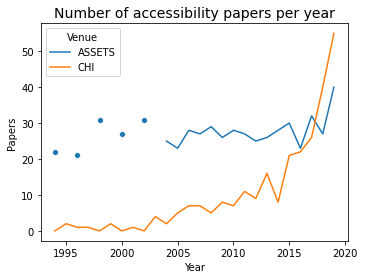

In [4]:
# plot counts over time
row_inds_lt_2004 = df_assets_chi_proportion['Year'] < 2004
row_inds_gteq_2004 = df_assets_chi_proportion['Year'] >= 2004

# biennial range of ASSETS
df_assets_biennial = df_assets_chi_proportion[['Year','ASSETS']][row_inds_lt_2004]
df_assets_biennial = df_assets_biennial[df_assets_biennial['ASSETS'] != 0]

# annual range of ASSETS and CHI
df_assets_annual = df_assets_chi_proportion[['Year','ASSETS']][row_inds_gteq_2004]
df_chi_annual = df_assets_chi_proportion[['Year','CHI']]

annual_counts = []
for idx, entry in df_assets_annual.iterrows():
    annual_counts.append([entry['Year'], entry['ASSETS'], 'ASSETS'])
for idx, entry in df_chi_annual.iterrows():
    annual_counts.append([entry['Year'], entry['CHI'], 'CHI'])
    
df_annual = pd.DataFrame(annual_counts, columns=['Year', 'Count', 'Venue'])

plt.close()
fig, ax = plt.subplots(figsize=(5.5, 4))
# ax = sns.set_style(style=None, rc=None )

colors = sns.color_palette()

sns.lineplot(
    ax=ax,
    data=df_assets_biennial,
    x='Year',
    y='ASSETS',
    marker='o', 
    linestyle='',
    color=colors[0]
)
sns.lineplot(
    ax=ax,
    data=df_annual,
    x='Year',
    y='Count',
    hue='Venue',
    markers=True,
    color=colors[0]
)

ax.set_title('Number of accessibility papers per year', fontsize=14)
ax.set_ylabel('Papers')

plt.show()

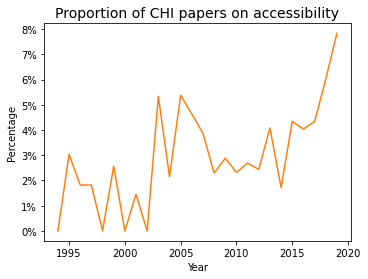

In [5]:
# plot proportion of CHI papers on accessbility
plt.close()
fig, ax = plt.subplots(figsize=(5.5, 4))

df_assets_chi_proportion['CHI percent'] = 100 * df_assets_chi_proportion['CHI proportion']

sns.lineplot(
    ax=ax,
    data=df_assets_chi_proportion,
    x='Year',
    y='CHI percent',
    color=colors[1],
    markers=True
)

fmt = '%.0f%%' 
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)
ax.set_title('Proportion of CHI papers on accessibility', fontsize=14)
ax.set_ylabel('Percentage')

plt.show()


## Keyword analysis

We define three keyword groups, for keywords related to community of focus, methods, and technology.

Keyword mappings are available in `dataset/Dataset2_KeywordMappings.csv`. Any author keywords that occur at least twice in our set of papers was annotated by two authors for keyword group, and a cluster code within that group.

We enrich the author keywords by detecting author keywords in the title and abstract of each paper in our dataset. We aggregate all keywords by categories as defined in the paper.

We then plot keyword trends over time based on these categories.

In [6]:
# load mappings and filter for keywords in three groups
kw_cats = {'human', 'method', 'technology'}

CAT_NAME_DICT = {
    "human": "Community of Focus",
    "technology": "Technology",
    "method": "Method"
}

df = pd.read_csv(KEYWORD_MAPPING_FILE)
df = df[['keyword', 'theme_code', 'category_code']]
df = df.loc[df['theme_code'].isin(kw_cats)]
display(df)

,keyword,theme_code,category_code
2,blind,human,blind and low vision
3,visual impairment,human,blind and low vision
4,blindness,human,blind and low vision
5,visually impaired,human,blind and low vision
6,older adults,human,older adults
...,...,...,...
487,wheelchair,technology,wheelchair
488,white cane,technology,white cane
489,camera,technology,camera
490,word processing,technology,word processing


In [7]:
# Process a11y paper data to enrich keywords

# remove html tags from string
def clean_str(s: str) -> str:
    clean = re.compile('<.*?>')
    return html.unescape(re.sub(clean, '', s))

# flatten list of lists
def flatten(l: List) -> List:
    return [item for sublist in l for item in sublist]

# reverse mapping dict
def reverse_dict(d: Dict[str, Iterable]) -> Dict:
    rev_dict = dict()
    for k, vs in d.items():
        for v in vs:
            rev_dict[v] = k
    return rev_dict

# check if token sequence contains subsequence
def has_tok_seq(main_seq, subseq):
    for i, _ in enumerate(main_seq):
        if main_seq[i:i+len(subseq)] == subseq:
            return True
    return False

# get kws
cat_mapping, cat_kws, cat_kw_toks, map_dict, reverse_map = dict(), dict(), dict(), dict(), dict()

for cat_name in kw_cats:
    cat_mapping[cat_name] = df[df.theme_code == cat_name]
    cat_kws[cat_name] = cat_mapping[cat_name].keyword.dropna().unique()
    cat_kw_toks[cat_name] = {kw: word_tokenize(kw) for kw in cat_kws[cat_name]}

    # create kw mapping
    map_dict[cat_name] = defaultdict(set)
    for kw, agg in zip(cat_mapping[cat_name].keyword, cat_mapping[cat_name]['category_code']):
        map_dict[cat_name][agg].add(kw)
    reverse_map[cat_name] = reverse_dict(map_dict[cat_name])
    
# read a11y papers and group by human kw cluster
a11y_papers = []
with open(A11Y_PAPER_METADATA_FILE, 'r') as f:
    reader = csv.DictReader(f)
    for entry in reader:
        entry['DOI'] = entry['\ufeffDOI']
        entry['year'] = int(entry['year'])
        entry['title'] = clean_str(entry['title'])
        entry['subtitle'] = clean_str(entry['subtitle'])
        entry['fulltitle'] = f"{entry['title']} : {entry['subtitle']}"
        entry['title_toks'] = word_tokenize(entry['fulltitle'].lower())
        entry['abstract'] = clean_str(entry['abstract'])
        entry['abstract_toks'] = word_tokenize(entry['abstract'].lower())
        entry['kw_list'] = [kw.strip().lower() for kw in entry['keywords'].split(',')]
        entry['keywords'] = ','.join(entry['kw_list'])
        del entry['\ufeffDOI']
        for cat_name in kw_cats:
            entry[f'{cat_name}_kws_in_title'] = [kw for kw, kw_seq in cat_kw_toks[cat_name].items() if has_tok_seq(entry['title_toks'], kw_seq)]
            entry[f'{cat_name}_kws_in_abstract'] = [kw for kw, kw_seq in cat_kw_toks[cat_name].items() if has_tok_seq(entry['abstract_toks'], kw_seq)]
            entry[f'{cat_name}_kws_in_title_abs'] = list(set(entry[f'{cat_name}_kws_in_title']) | set(entry[f'{cat_name}_kws_in_abstract']))
            entry[f'{cat_name}_kw_cats'] = list(set([reverse_map[cat_name][kw] for kw in entry['kw_list'] if kw in reverse_map[cat_name]]))
            entry[f'all_{cat_name}_cats'] = list(set(entry[f'{cat_name}_kw_cats']) | set(
                [reverse_map[cat_name][kw] for kw in set(entry[f'{cat_name}_kws_in_title'] + entry[f'{cat_name}_kws_in_abstract']
            ) if kw in reverse_map[cat_name]]))
            if not(entry[f'{cat_name}_kw_cats']):
                entry[f'{cat_name}_kw_cats'] = ['none']
            if not(entry[f'all_{cat_name}_cats']):
                entry[f'all_{cat_name}_cats'] = ['none']
            entry[f'normalized_all_{cat_name}_cats'] = {
                kw: 1. / (len(entry[f'all_{cat_name}_cats']))
                for kw in entry[f'all_{cat_name}_cats']
            }
        a11y_papers.append(entry)
        
print(f'{len(a11y_papers)} papers processed.')


836 papers processed.


In [8]:
# number of papers with enriched keywords and without keyword info per category
kw_in_title_abstract = dict()
kw_none_counts = dict()
for cat_name in kw_cats:
    kw_in_title_abstract[cat_name] = [
        p for p in a11y_papers
        if set(p[f'{cat_name}_kw_cats']) == {'none'}
        and p[f'all_{cat_name}_cats']
        and set(p[f'all_{cat_name}_cats']) != {'none'}
    ]
    print(f'{len(kw_in_title_abstract[cat_name])} papers with additional {CAT_NAME_DICT[cat_name]} information.')
    kw_none_counts[cat_name] = [p for p in a11y_papers if set(p[f'all_{cat_name}_cats']) == {'none'}]
    print(f'{len(kw_none_counts[cat_name])} papers without {CAT_NAME_DICT[cat_name]} information.')
    print()
    

204 papers with additional Technology information.
108 papers without Technology information.

398 papers with additional Method information.
285 papers without Method information.

202 papers with additional Community of Focus information.
125 papers without Community of Focus information.



In [9]:
# get keyword counts by year by category
year_range = range(1994, 2020)
kw_counts_by_year = defaultdict(lambda: defaultdict(list))
cat_counts_by_year = defaultdict(lambda: defaultdict(list))
norm_cat_counts_by_year = defaultdict(lambda: defaultdict(list))
for cat_name in kw_cats:
    for kw, mapped_cat in reverse_map[cat_name].items():
        year_matches = Counter([
            entry['year'] for entry in a11y_papers
            if kw in entry[f'{cat_name}_kws_in_title_abs']
               or kw in entry['kw_list']
        ])
        counts_by_year = [year_matches.get(yr, 0) for yr in year_range]
        kw_counts_by_year[cat_name][cat_name].append([kw, mapped_cat] + counts_by_year)
    for kw_cat in map_dict[cat_name].keys():
        year_matches = Counter([
            entry['year'] for entry in a11y_papers
            if kw_cat in entry[f'all_{cat_name}_cats']
        ])
        cat_counts_by_year[cat_name][kw_cat] = [year_matches.get(yr, 0) for yr in year_range]
    for kw_cat in map_dict[cat_name].keys():
        norm_entry = []
        year_matches = [
            (entry['year'], entry[f'normalized_all_{cat_name}_cats'][kw_cat])
            for entry in a11y_papers
            if kw_cat in entry[f'normalized_all_{cat_name}_cats']
        ]
        for yr in year_range:
            that_yr_matches = [m[1] for m in year_matches if m[0] == yr]
            norm_entry.append(sum(that_yr_matches) if that_yr_matches else 0.)
        norm_cat_counts_by_year[cat_name][kw_cat] = norm_entry
        
print('Computed keyword counts per aggregate category.')


Computed keyword counts per aggregate category.


In [10]:
# proportion of normalized counts (used to generate Table 5)
sum_by_cat = dict()
for cat_name in kw_cats:
    sum_by_cat[cat_name] = np.sum([
        values for kw, values in norm_cat_counts_by_year[cat_name].items()
    ], axis=0)
    
proportion_by_year = defaultdict(dict)
for cat_name in norm_cat_counts_by_year:
    for kw, counts in norm_cat_counts_by_year[cat_name].items():
        prop = [ct / sm if sm != 0 else float('nan') for ct, sm in zip(counts, sum_by_cat[cat_name])]
        proportion_by_year[cat_name][kw] = prop
        
headers = ['top_cat', 'mapped_cat'] + list(year_range)
proportion_as_table = []
for cat_name in proportion_by_year:
    for kw in proportion_by_year[cat_name]:
        proportion_as_table.append([cat_name, kw] + proportion_by_year[cat_name][kw])
        
df_prop = pd.DataFrame(proportion_as_table, columns=headers)

display(df_prop)


,top_cat,mapped_cat,1994,1995,1996,1997,1998,1999,2000,2001,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,technology,web,0.147059,0.0,0.066667,0.25,0.159195,0.0,0.167949,NaN,...,0.070578,0.112745,0.101111,0.092437,0.039063,0.029167,0.031250,0.016846,0.062147,0.044889
1,technology,3d printing/diy/fab,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.000000,NaN,...,0.000000,0.009804,0.000000,0.000000,0.031250,0.047917,0.066111,0.031447,0.004944,0.042222
2,technology,AR/MR/VR,0.000000,0.0,0.012500,0.00,0.021264,0.0,0.022436,NaN,...,0.000000,0.000000,0.016667,0.003268,0.003906,0.028571,0.025833,0.018868,0.055085,0.036000
3,technology,mobile,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.019231,NaN,...,0.078571,0.090686,0.078095,0.123810,0.118527,0.056488,0.110754,0.078931,0.101695,0.076212
4,technology,screen readers,0.039216,0.0,0.000000,0.00,0.011494,0.0,0.000000,NaN,...,0.043793,0.000000,0.044444,0.003268,0.039063,0.035417,0.024405,0.038544,0.030932,0.038593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,human,intellectual/developmental disability,0.000000,0.0,0.000000,NaN,0.014493,0.0,0.000000,0.0,...,0.016129,0.014286,0.000000,0.000000,0.007143,0.016304,0.025641,0.006410,0.005376,0.024390
151,human,general,0.115385,0.0,0.104902,NaN,0.086957,0.0,0.157895,0.0,...,0.032258,0.071429,0.016129,0.013158,0.028571,0.021739,0.038462,0.025641,0.069892,0.030488
152,human,mental health,0.000000,0.0,0.000000,NaN,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.052632,0.014286,0.032609,0.008547,0.000000,0.016129,0.024390
153,human,other or unclear,0.102564,0.0,0.011765,NaN,0.014493,0.0,0.026316,0.0,...,0.056452,0.014286,0.016129,0.013158,0.000000,0.023551,0.047009,0.016026,0.048387,0.012195
